In [1]:
# 0. Setup
import os
from pathlib import Path
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"

def missing_report(df: pd.DataFrame) -> pd.DataFrame:
    """Missingness summary (counts + %), sorted high->low."""
    n = len(df)
    out = (df.isna().sum()
             .to_frame("missing_n")
             .assign(missing_pct=lambda x: (x["missing_n"] / n * 100).round(2))
             .sort_values(["missing_n", "missing_pct"], ascending=False))
    return out

def duplicate_report(df: pd.DataFrame, subset=None) -> dict:
    """Duplicate counts for whole rows or a key subset."""
    if subset is None:
        return {"duplicate_rows": int(df.duplicated().sum())}
    return {"duplicate_key_rows": int(df.duplicated(subset=subset).sum())}

def infer_id_like_columns(df: pd.DataFrame) -> list[str]:
    """Heuristic: columns with 'id' in name or high uniqueness."""
    id_cols = [c for c in df.columns if "id" in c.lower()]
    # high-uniqueness numeric/object columns can be ids too
    for c in df.columns:
        nunique = df[c].nunique(dropna=True)
        if nunique / max(len(df), 1) > 0.95:
            id_cols.append(c)
    return sorted(set(id_cols))

def infer_measure_like_columns(df: pd.DataFrame) -> list[str]:
    """Heuristic: numeric columns excluding obvious IDs."""
    numeric = df.select_dtypes(include="number").columns.tolist()
    id_like = set(infer_id_like_columns(df))
    return [c for c in numeric if c not in id_like]

def parse_date_column(df: pd.DataFrame, candidates=("date", "order_date", "transaction_date", "dt")) -> tuple[pd.DataFrame, str|None]:
    """Try to parse a date-like column; return df + chosen column name (or None)."""
    for c in df.columns:
        if any(k in c.lower() for k in candidates):
            try:
                df[c] = pd.to_datetime(df[c], errors="coerce")
                if df[c].notna().any():
                    return df, c
            except Exception:
                pass
    return df, None


In [2]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path("..") / "data" / "raw" / "Online_Retail.csv"

df = pd.read_csv(DATA_PATH, encoding="ISO-8859-1")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


# 1. Data overview

In [4]:
df.shape

(541909, 8)

In [5]:

df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country'], dtype='object')

In [6]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:

df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01/12/2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01/12/2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01/12/2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01/12/2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01/12/2010 08:34,1.69,13047.0,United Kingdom


# 2. Data quality checks

In [8]:
df.isna().sum().sort_values(ascending=False)


CustomerID     135080
Description      1454
StockCode           0
InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [9]:
df.duplicated().sum()


np.int64(5268)

In [10]:
(df["Quantity"] <= 0).sum(), (df["UnitPrice"] <= 0).sum()


(np.int64(10624), np.int64(2517))

# 3. Temporal coverage


In [12]:

df["InvoiceDate"] = pd.to_datetime(
    df["InvoiceDate"],
    dayfirst=True,
    errors="coerce"
)


In [13]:
df["InvoiceDate"].isna().sum()


np.int64(0)

In [14]:
df["InvoiceDate"].min(), df["InvoiceDate"].max()


(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [15]:
df["InvoiceDate"].dt.to_period("M").value_counts().sort_index()


InvoiceDate
2010-12    42481
2011-01    35147
2011-02    27707
2011-03    36748
2011-04    29916
2011-05    37030
2011-06    36874
2011-07    39518
2011-08    35284
2011-09    50226
2011-10    60742
2011-11    84711
2011-12    25525
Freq: M, Name: count, dtype: int64

In [16]:
df.loc[df["InvoiceDate"].isna(), ["InvoiceDate"]].head()


,InvoiceDate


# 4. Grain (unit of analysis)


In [17]:
df.nunique().sort_values(ascending=False)


InvoiceNo      25900
InvoiceDate    23260
CustomerID      4372
Description     4223
StockCode       4070
UnitPrice       1630
Quantity         722
Country           38
dtype: int64

In [18]:
df[["InvoiceNo", "StockCode"]].duplicated().sum()


np.int64(10684)

# summary of raw data

- **Unit of analysis:** One row represents a single product line within an invoice.
- **Time coverage:** min: (Timestamp('2010-12-01 08:26:00'), max: Timestamp('2011-12-09 12:50:00'))
- **Identifiers:** InvoiceNo, StockCode, CustomerID
- **Measures:** Quantity, UnitPrice
- **Key data issues:** Missing CustomerID; negative quantities indicating returns.


# Cleaning data

In [19]:
df_clean = df.copy()


In [20]:
df_clean = df_clean[df_clean["Quantity"] > 0]


In [21]:
df_clean = df_clean[df_clean["UnitPrice"] > 0]


In [22]:
df_clean = df_clean.dropna(subset=["CustomerID"])


In [23]:
df_clean["Revenue"] = df_clean["Quantity"] * df_clean["UnitPrice"]


In [24]:
df.shape, df_clean.shape


((541909, 8), (397884, 9))

In [25]:
df_clean[["Quantity", "UnitPrice", "Revenue"]].describe()


,Quantity,UnitPrice,Revenue
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,22.397000
std,179.331775,22.097877,309.071041
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.680000
50%,6.000000,1.950000,11.800000
75%,12.000000,3.750000,19.800000
max,80995.000000,8142.750000,168469.600000


In [26]:
df_clean["InvoiceDate"].min(), df_clean["InvoiceDate"].max()


(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

## Cleaning decisions

- Removed returns and cancellations (Quantity ≤ 0)
- Removed zero/negative prices
- Dropped transactions without CustomerID
- Defined Revenue = Quantity × UnitPrice

This dataset now represents valid customer purchase events.


# RFM(Recency, Frequency, Monetary)

In [27]:
snapshot_date = df_clean["InvoiceDate"].max() + pd.Timedelta(days=1)
snapshot_date


Timestamp('2011-12-10 12:50:00')

In [28]:
rfm = (
    df_clean
    .groupby("CustomerID")
    .agg(
        Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
        Frequency=("InvoiceNo", "nunique"),
        Monetary=("Revenue", "sum")
    )
    .reset_index()
)
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [29]:
rfm.describe()


,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


In [33]:
rfm["R_score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])
rfm["F_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm["M_score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5])


In [34]:
# After creating R_score, F_score, M_score:
rfm["R_score"] = rfm["R_score"].astype(int)
rfm["F_score"] = rfm["F_score"].astype(int)
rfm["M_score"] = rfm["M_score"].astype(int)

rfm["RFM_Score"] = (
    rfm["R_score"].astype(str)
    + rfm["F_score"].astype(str)
    + rfm["M_score"].astype(str)
)


In [35]:
def rfm_segment(row):
    if row["RFM_Score"] == "555":
        return "Champions"
    if row["R_score"] >= 4 and row["F_score"] >= 4:
        return "Loyal"
    if row["R_score"] >= 4:
        return "Recent"
    if row["F_score"] >= 4:
        return "Frequent"
    if row["M_score"] >= 4:
        return "High Value"
    return "Others"

rfm["Segment"] = rfm.apply(rfm_segment, axis=1)
rfm["Segment"].value_counts()


Segment
Others        1713
Loyal          791
Recent         633
Frequent       596
Champions      348
High Value     257
Name: count, dtype: int64

## RFM interpretation

- Champions and Loyal customers drive a disproportionate share of revenue and should be prioritised for retention.
- Recent customers represent growth potential and require conversion to repeat buyers.
- High-value but inactive customers indicate churn risk and are candidates for reactivation.
- Low RFM customers contribute marginal value and warrant minimal marketing investment.


## Frequency distribution

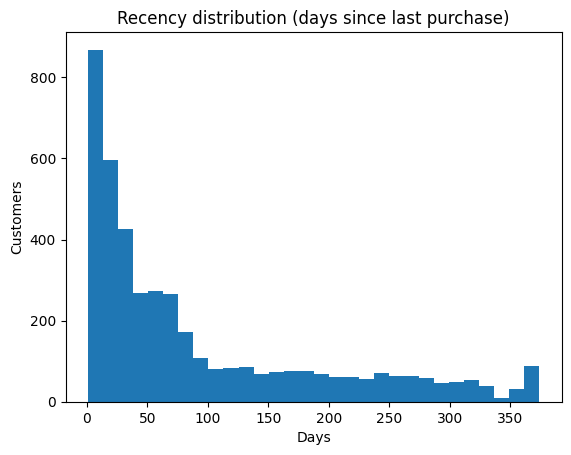

In [36]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(rfm["Recency"], bins=30)
plt.title("Recency distribution (days since last purchase)")
plt.xlabel("Days")
plt.ylabel("Customers")
plt.show()


## Monetary distribution

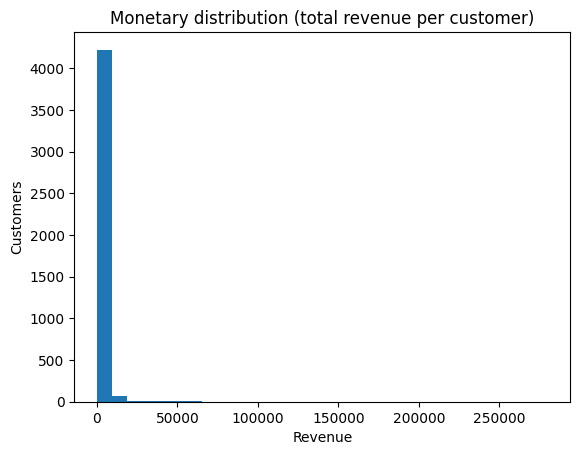

In [37]:
plt.figure()
plt.hist(rfm["Monetary"], bins=30)
plt.title("Monetary distribution (total revenue per customer)")
plt.xlabel("Revenue")
plt.ylabel("Customers")
plt.show()


## Segment Size(how many customers per segment)

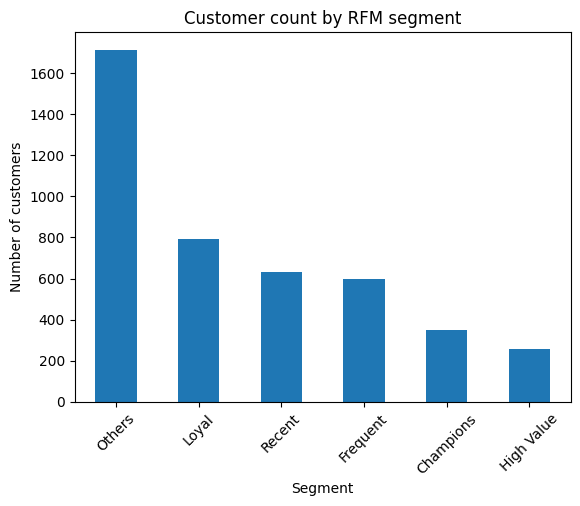

In [38]:
segment_counts = rfm["Segment"].value_counts()

plt.figure()
segment_counts.plot(kind="bar")
plt.title("Customer count by RFM segment")
plt.xlabel("Segment")
plt.ylabel("Number of customers")
plt.xticks(rotation=45)
plt.show()


## Revenue contribution by segment (most important plot)

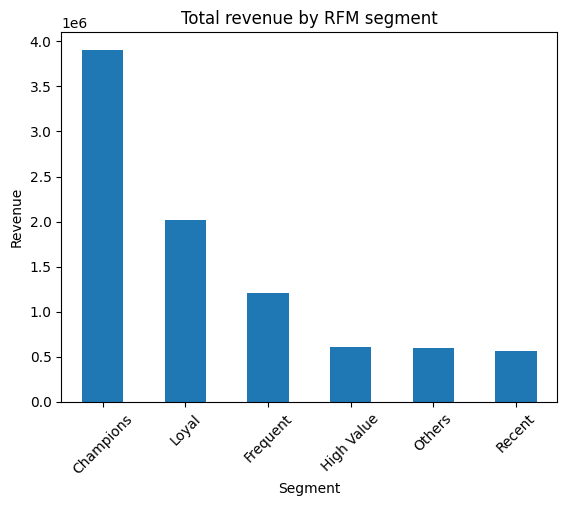

In [39]:
segment_revenue = (
    rfm.merge(
        df_clean.groupby("CustomerID", as_index=False)["Revenue"].sum(),
        on="CustomerID"
    )
    .groupby("Segment")["Revenue"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure()
segment_revenue.plot(kind="bar")
plt.title("Total revenue by RFM segment")
plt.xlabel("Segment")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()


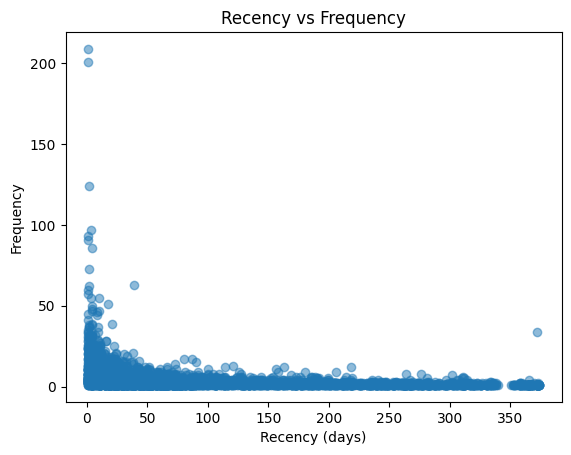

In [40]:
plt.figure()
plt.scatter(rfm["Recency"], rfm["Frequency"], alpha=0.5)
plt.title("Recency vs Frequency")
plt.xlabel("Recency (days)")
plt.ylabel("Frequency")
plt.show()


## RFM visual insights

- Recency and frequency distributions are highly skewed, indicating that most customers purchase infrequently.
- A small number of customers account for a disproportionate share of total revenue.
- Champion and Loyal segments contribute significantly more revenue relative to their size.
- There is a clear behavioural separation between recent high-frequency customers and inactive low-frequency customers.


In [41]:
from pathlib import Path

EXPORT_DIR = Path("..") / "data" / "processed"
EXPORT_DIR.mkdir(parents=True, exist_ok=True)


In [42]:
rfm_export = rfm.copy()

rfm_export.head()


,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Segment
0,12346.0,326,1,77183.60,1,1,5,115,High Value
1,12347.0,2,7,4310.00,5,5,5,555,Champions
2,12348.0,75,4,1797.24,2,4,4,244,Frequent
3,12349.0,19,1,1757.55,4,1,4,414,Recent
4,12350.0,310,1,334.40,1,1,2,112,Others


In [43]:
rfm_export.to_csv(
    EXPORT_DIR / "rfm_customers.csv",
    index=False
)


In [44]:
segment_summary = (
    rfm_export
    .groupby("Segment")
    .agg(
        customers=("CustomerID", "count"),
        revenue=("Monetary", "sum"),
        avg_revenue=("Monetary", "mean")
    )
    .reset_index()
)

segment_summary


,Segment,customers,revenue,avg_revenue
0,Champions,348,3905165.910,11221.741121
1,Frequent,596,1209093.950,2028.681124
2,High Value,257,611714.761,2380.213078
3,Loyal,791,2022558.001,2556.963339
4,Others,1713,602217.072,351.556960
5,Recent,633,560658.210,885.715972


In [45]:
segment_summary.to_csv(
    EXPORT_DIR / "rfm_segment_summary.csv",
    index=False
)


## Exported outputs

- `data/processed/rfm_customers.csv`: customer-level RFM metrics and segments
- `data/processed/rfm_segment_summary.csv`: segment-level customer counts and revenue
